## CVaR-VQA Based Quantum Seed Generator for LABS

This notebook implements a **Variational Quantum Seed Generator** inspired by the sampling-based CVaR-VQA workflow from [arXiv:2508.13557](https://arxiv.org/html/2508.13557). 

### Key Idea
Rather than embedding the full 4-local LABS Hamiltonian into the quantum circuit, we:
1. **Sample** candidate LABS bitstrings from a parametrized quantum circuit
2. **Evaluate** the LABS energy classically on each sampled bitstring
3. **Aggregate** low-energy samples via CVaR (Conditional Value at Risk) objective
4. **Optimize** circuit parameters with a classical optimizer (COBYLA/SPSA) to bias sampling toward better seeds

The quantum stage serves as a **seed-quality amplifier** - its output is passed to Memetic Tabu Search (MTS), creating a quantum-classical memetic pipeline. We aim to bias the sampling distribution toward low-energy sequences so MTS starts from a better initial pool.

In [1]:
import cudaq
import numpy as np
from scipy.optimize import minimize
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

# Set CUDA-Q target to CPU simulator
cudaq.set_target("nvidia")

print(f"CUDA-Q version: {cudaq.__version__}")
print(f"Target: {cudaq.get_target().name}")


CUDA-Q version: CUDA-Q Version amd64-cu13-0.13.0 (https://github.com/NVIDIA/cuda-quantum b66c5bb7fd8c08e5014e2f03e97e7b0e92691650)
Target: nvidia


## Section 1: LABS Energy Function and CVaR Aggregation

The LABS energy is computed classically on sampled bitstrings:
$$E(s) = \sum_{k=1}^{N-1} C_k^2 \quad \text{where} \quad C_k = \sum_{i=1}^{N-k} s_i s_{i+k}$$

CVaR (Conditional Value at Risk) with parameter $\alpha \in (0,1]$ computes the mean of the lowest $\alpha$-quantile of energy values, biasing optimization toward low-energy samples.

In [2]:
# =============================================================================
# LABS Energy Function
# =============================================================================

def labs_energy(s: np.ndarray) -> int:
    """
    Compute LABS energy E(s) = sum_{k=1}^{N-1} C_k^2 for s in {-1,+1}^N.
    
    Args:
        s: Binary sequence in {-1, +1}^N
        
    Returns:
        Integer energy value (sum of squared autocorrelations)
    """
    s = np.asarray(s, dtype=int)
    N = s.size
    C = [np.dot(s[:N-k], s[k:]) for k in range(1, N)]
    return int(np.sum(np.square(C)))


def bits_to_pm1(bitstr: str) -> np.ndarray:
    """
    Convert a bitstring '01101...' to {-1, +1}^N array.
    Convention: '0' -> -1, '1' -> +1
    """
    return np.array([1 if b == "1" else -1 for b in bitstr], dtype=int)


def pm1_to_bits(s: np.ndarray) -> str:
    """Convert {-1, +1}^N array to bitstring."""
    return "".join("1" if x == 1 else "0" for x in s)


def random_sequence(N: int, rng: np.random.Generator) -> np.ndarray:
    """Generate random binary sequence in {-1, +1}^N."""
    return rng.choice([-1, 1], size=N)


# =============================================================================
# CVaR Aggregation
# =============================================================================

def cvar_from_samples(energies: np.ndarray, alpha: float = 0.2) -> float:
    """
    Compute CVaR (Conditional Value at Risk) of energy samples.
    
    CVaR_α is the mean of the lowest α-quantile of samples.
    - α = 1.0: standard expectation (mean of all samples)
    - α → 0: approaches minimum energy
    - α ∈ (0, 1): focuses on low-energy tail
    
    Args:
        energies: Array of energy values from samples
        alpha: CVaR parameter (default 0.2 = lowest 20%)
        
    Returns:
        CVaR value (float)
    """
    if alpha <= 0 or alpha > 1:
        raise ValueError("alpha must be in (0, 1]")
    
    sorted_energies = np.sort(energies)
    n_samples = len(energies)
    k = max(1, int(np.ceil(alpha * n_samples)))
    
    return float(np.mean(sorted_energies[:k]))


def compute_energies_from_counts(counts: dict) -> tuple:
    """
    Compute LABS energy for each sample in counts dict.
    
    Args:
        counts: Dictionary {bitstring: count}
        
    Returns:
        energies: Array of all energy values (with repetitions)
        bitstrings: List of corresponding bitstrings
    """
    energies = []
    bitstrings = []
    
    for bitstr, count in counts.items():
        e = labs_energy(bits_to_pm1(bitstr))
        for _ in range(count):
            energies.append(e)
            bitstrings.append(bitstr)
    
    return np.array(energies), bitstrings


# Test the functions
print("Testing LABS energy function:")
test_seq = np.array([1, 1, 1, -1, -1, 1, -1])  # N=7
print(f"  Sequence: {test_seq}")
print(f"  Energy: {labs_energy(test_seq)}")

print("\nTesting CVaR aggregation:")
test_energies = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
print(f"  Energies: {test_energies}")
print(f"  CVaR(α=0.2): {cvar_from_samples(test_energies, alpha=0.2)}")
print(f"  CVaR(α=0.5): {cvar_from_samples(test_energies, alpha=0.5)}")
print(f"  CVaR(α=1.0): {cvar_from_samples(test_energies, alpha=1.0)}")


Testing LABS energy function:
  Sequence: [ 1  1  1 -1 -1  1 -1]
  Energy: 3

Testing CVaR aggregation:
  Energies: [ 10  20  30  40  50  60  70  80  90 100]
  CVaR(α=0.2): 15.0
  CVaR(α=0.5): 30.0
  CVaR(α=1.0): 55.0


## Section 2: Parametrized Quantum Ansatz for CVaR-VQA

We use a **hardware-efficient ansatz** with layers of:
1. Single-qubit rotation gates (RY, RZ) with variational parameters
2. Entangling layers (CNOT gates in a ladder pattern)

The ansatz is designed to efficiently explore the search space while remaining realizable on near-term quantum hardware.


In [3]:
# =============================================================================
# Parametrized Quantum Ansatz using CUDA-Q
# =============================================================================

@cudaq.kernel
def hardware_efficient_ansatz(n_qubits: int, n_layers: int, params: list[float]):
    """
    Hardware-efficient variational ansatz for CVaR-VQA.
    
    Structure per layer:
    1. RY rotation on each qubit
    2. RZ rotation on each qubit  
    3. CNOT ladder entanglement
    
    Total parameters: n_layers * n_qubits * 2
    
    Args:
        n_qubits: Number of qubits (= sequence length N)
        n_layers: Number of variational layers
        params: Flat list of variational parameters
    """
    qubits = cudaq.qvector(n_qubits)
    
    # Initialize in superposition
    for i in range(n_qubits):
        h(qubits[i])
    
    # Variational layers
    param_idx = 0
    for layer in range(n_layers):
        # Single-qubit rotations: RY
        for i in range(n_qubits):
            ry(params[param_idx], qubits[i])
            param_idx += 1
        
        # Single-qubit rotations: RZ
        for i in range(n_qubits):
            rz(params[param_idx], qubits[i])
            param_idx += 1
        
        # Entangling layer: CNOT ladder
        for i in range(n_qubits - 1):
            x.ctrl(qubits[i], qubits[i + 1])


@cudaq.kernel
def problem_inspired_ansatz(n_qubits: int, n_layers: int, params: list[float]):
    """
    Problem-inspired ansatz with ZZ interactions (similar to QAOA mixer).
    
    Structure per layer:
    1. RY rotation on each qubit
    2. RZZ interactions between neighboring qubits
    3. RX rotation on each qubit (mixer-like)
    
    Total parameters: n_layers * (n_qubits * 2 + (n_qubits - 1))
    """
    qubits = cudaq.qvector(n_qubits)
    
    # Initialize in superposition
    for i in range(n_qubits):
        h(qubits[i])
    
    param_idx = 0
    for layer in range(n_layers):
        # RY rotations
        for i in range(n_qubits):
            ry(params[param_idx], qubits[i])
            param_idx += 1
        
        # ZZ interactions (problem-inspired entanglement)
        for i in range(n_qubits - 1):
            # RZZ gate via CNOT-RZ-CNOT
            x.ctrl(qubits[i], qubits[i + 1])
            rz(params[param_idx], qubits[i + 1])
            x.ctrl(qubits[i], qubits[i + 1])
            param_idx += 1
        
        # RX rotations (mixer)
        for i in range(n_qubits):
            rx(params[param_idx], qubits[i])
            param_idx += 1


def count_params_hardware_efficient(n_qubits: int, n_layers: int) -> int:
    """Number of parameters for hardware-efficient ansatz."""
    return n_layers * n_qubits * 2


def count_params_problem_inspired(n_qubits: int, n_layers: int) -> int:
    """Number of parameters for problem-inspired ansatz."""
    return n_layers * (n_qubits * 2 + (n_qubits - 1))


# Test the ansatz
N_test = 5
n_layers_test = 2
n_params = count_params_hardware_efficient(N_test, n_layers_test)
print(f"Hardware-efficient ansatz test:")
print(f"  N={N_test}, layers={n_layers_test}, params={n_params}")

# Sample with random parameters
rng = np.random.default_rng(42)
test_params = list(rng.uniform(0, 2*np.pi, size=n_params))
test_counts = cudaq.sample(hardware_efficient_ansatz, N_test, n_layers_test, test_params, shots_count=100)
print(f"  Sample counts (first 5): {dict(list(test_counts.items())[:5])}")


Hardware-efficient ansatz test:
  N=5, layers=2, params=20
  Sample counts (first 5): {'01111': 1, '10011': 10, '11011': 5, '10000': 11, '01000': 1}


## Section 3: CVaR-VQA Optimization Loop

The core variational loop:
1. Sample bitstrings from the parametrized circuit
2. Evaluate LABS energy classically on each sample
3. Compute CVaR objective from the energy distribution
4. Use a classical optimizer (COBYLA) to update parameters


In [4]:
# =============================================================================
# CVaR-VQA Optimizer
# =============================================================================

class CVaRVQAOptimizer:
    """
    CVaR-VQA optimizer for LABS problem.
    
    Implements the sampling-based variational workflow from arXiv:2508.13557:
    1. Sample bitstrings from parametrized quantum circuit
    2. Evaluate LABS energy classically
    3. Aggregate via CVaR objective
    4. Update parameters with classical optimizer
    """
    
    def __init__(
        self,
        n_qubits: int,
        n_layers: int = 3,
        cvar_alpha: float = 0.2,
        shots_per_iter: int = 512,
        ansatz_type: str = "hardware_efficient",
        seed: int = None
    ):
        """
        Initialize CVaR-VQA optimizer.
        
        Args:
            n_qubits: Number of qubits (sequence length N)
            n_layers: Number of ansatz layers
            cvar_alpha: CVaR parameter (0 < alpha <= 1)
            shots_per_iter: Number of samples per optimization iteration
            ansatz_type: "hardware_efficient" or "problem_inspired"
            seed: Random seed for reproducibility
        """
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.cvar_alpha = cvar_alpha
        self.shots = shots_per_iter
        self.ansatz_type = ansatz_type
        self.rng = np.random.default_rng(seed)
        
        # Select ansatz and count parameters
        if ansatz_type == "hardware_efficient":
            self.ansatz = hardware_efficient_ansatz
            self.n_params = count_params_hardware_efficient(n_qubits, n_layers)
        else:
            self.ansatz = problem_inspired_ansatz
            self.n_params = count_params_problem_inspired(n_qubits, n_layers)
        
        # Optimization tracking
        self.iteration = 0
        self.history = {
            'cvar': [],
            'min_energy': [],
            'mean_energy': [],
            'best_bitstring': None,
            'best_energy': float('inf')
        }
        self.all_samples = {}  # Store all unique samples found
    
    def _objective(self, params: np.ndarray) -> float:
        """
        CVaR objective function for optimization.
        
        Args:
            params: Current parameter values
            
        Returns:
            CVaR value (to be minimized)
        """
        # Sample from quantum circuit
        params_list = list(params)
        counts = cudaq.sample(
            self.ansatz, 
            self.n_qubits, 
            self.n_layers, 
            params_list, 
            shots_count=self.shots
        )
        
        # Compute energies for all samples
        energies, bitstrings = compute_energies_from_counts(counts)
        
        # Store unique samples
        for bitstr, count in counts.items():
            e = labs_energy(bits_to_pm1(bitstr))
            if bitstr not in self.all_samples or e < self.all_samples[bitstr]:
                self.all_samples[bitstr] = e
        
        # Compute CVaR
        cvar_val = cvar_from_samples(energies, self.cvar_alpha)
        
        # Track best solution found
        min_e = int(np.min(energies))
        if min_e < self.history['best_energy']:
            self.history['best_energy'] = min_e
            best_idx = np.argmin(energies)
            self.history['best_bitstring'] = bitstrings[best_idx]
        
        # Record history
        self.history['cvar'].append(cvar_val)
        self.history['min_energy'].append(min_e)
        self.history['mean_energy'].append(float(np.mean(energies)))
        
        self.iteration += 1
        if self.iteration % 10 == 0:
            print(f"  Iter {self.iteration}: CVaR={cvar_val:.2f}, Min={min_e}, Mean={np.mean(energies):.2f}")
        
        return cvar_val
    
    def optimize(
        self,
        max_iterations: int = 100,
        initial_params: np.ndarray = None,
        method: str = "COBYLA"
    ) -> dict:
        """
        Run CVaR-VQA optimization.
        
        Args:
            max_iterations: Maximum optimizer iterations
            initial_params: Initial parameter values (random if None)
            method: Scipy optimizer method ("COBYLA", "Powell", "Nelder-Mead")
            
        Returns:
            Dictionary with optimal parameters and results
        """
        # Initialize parameters
        if initial_params is None:
            initial_params = self.rng.uniform(0, 2*np.pi, size=self.n_params)
        
        print(f"Starting CVaR-VQA optimization:")
        print(f"  N={self.n_qubits}, layers={self.n_layers}, params={self.n_params}")
        print(f"  CVaR α={self.cvar_alpha}, shots={self.shots}")
        print(f"  Optimizer: {method}")
        print()
        
        # Run optimization
        result = minimize(
            self._objective,
            initial_params,
            method=method,
            options={'maxiter': max_iterations, 'disp': False}
        )
        
        print(f"\nOptimization complete after {self.iteration} iterations")
        print(f"  Best energy found: {self.history['best_energy']}")
        print(f"  Best bitstring: {self.history['best_bitstring']}")
        print(f"  Final CVaR: {self.history['cvar'][-1]:.2f}")
        
        return {
            'optimal_params': result.x,
            'best_energy': self.history['best_energy'],
            'best_bitstring': self.history['best_bitstring'],
            'history': self.history,
            'all_samples': self.all_samples,
            'scipy_result': result
        }
    
    def sample_optimized(self, params: np.ndarray, shots: int = 2048) -> dict:
        """
        Sample from the optimized circuit.
        
        Args:
            params: Optimized parameters
            shots: Number of samples
            
        Returns:
            Counts dictionary
        """
        params_list = list(params)
        counts = cudaq.sample(
            self.ansatz,
            self.n_qubits,
            self.n_layers,
            params_list,
            shots_count=shots
        )
        return counts
    
    def get_top_samples(self, n_top: int = 20) -> list:
        """
        Get top N lowest-energy unique samples found during optimization.
        
        Args:
            n_top: Number of samples to return
            
        Returns:
            List of (bitstring, energy) tuples sorted by energy
        """
        sorted_samples = sorted(self.all_samples.items(), key=lambda x: x[1])
        return sorted_samples[:n_top]


def plot_optimization_history(history: dict, title: str = "CVaR-VQA Optimization"):
    """Plot optimization history."""
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    # CVaR over iterations
    axes[0].plot(history['cvar'], color='#2E86AB', linewidth=1.5)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('CVaR')
    axes[0].set_title('CVaR Objective')
    axes[0].grid(True, alpha=0.3)
    
    # Min energy over iterations
    axes[1].plot(history['min_energy'], color='#A23B72', linewidth=1.5, label='Min')
    axes[1].plot(history['mean_energy'], color='#F18F01', linewidth=1.5, alpha=0.7, label='Mean')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Energy')
    axes[1].set_title('Energy vs Iteration')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Running best
    running_best = np.minimum.accumulate(history['min_energy'])
    axes[2].plot(running_best, color='#76b900', linewidth=2)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('Best Energy')
    axes[2].set_title('Running Best Energy')
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


## Section 4: Memetic Tabu Search (MTS) Integration

The CVaR-VQA output serves as a high-quality seed population for MTS. The quantum stage biases the initial distribution toward low-energy sequences, giving MTS a better starting point.


In [5]:
# =============================================================================
# Memetic Tabu Search (MTS) Functions
# =============================================================================

def combine(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    """Single-point crossover between two parent sequences."""
    N = len(p1)
    k = rng.integers(1, N)  # crossover point in [1, N-1]
    return np.concatenate([p1[:k], p2[k:]])


def mutate(s: np.ndarray, p_mut: float, rng: np.random.Generator) -> np.ndarray:
    """Bit-flip mutation with probability p_mut per bit."""
    s = s.copy()
    for i in range(len(s)):
        if rng.random() < p_mut:
            s[i] *= -1
    return s


def tabu_search(
    s0: np.ndarray,
    max_iters: int = 200,
    tabu_tenure: int = 7
) -> tuple:
    """
    Tabu search with aspiration criterion.
    
    Args:
        s0: Initial sequence in {-1, +1}^N
        max_iters: Maximum iterations
        tabu_tenure: Number of iterations a move remains tabu
        
    Returns:
        (best_sequence, best_energy)
    """
    s = np.asarray(s0, dtype=int).copy()
    N = len(s)
    tabu = np.zeros(N, dtype=int)

    best = s.copy()
    best_energy = labs_energy(best)
    current_energy = best_energy

    for _ in range(max_iters):
        best_move = None
        best_move_energy = None

        for i in range(N):
            candidate = s.copy()
            candidate[i] *= -1
            cand_energy = labs_energy(candidate)

            # Tabu check with aspiration: allow if improves global best
            is_tabu = tabu[i] > 0
            if is_tabu and cand_energy >= best_energy:
                continue

            if best_move_energy is None or cand_energy < best_move_energy:
                best_move = i
                best_move_energy = cand_energy

        if best_move is None:
            break

        # Apply move
        s[best_move] *= -1
        current_energy = best_move_energy

        # Update tabu list
        tabu = np.maximum(tabu - 1, 0)
        tabu[best_move] = tabu_tenure

        # Update best
        if current_energy < best_energy:
            best_energy = current_energy
            best = s.copy()

    return best, best_energy


def population_from_counts(counts: dict, pop_size: int, rng: np.random.Generator) -> list:
    """
    Create population by sampling from quantum measurement counts.
    
    Args:
        counts: Dictionary {bitstring: count}
        pop_size: Desired population size
        rng: Random number generator
        
    Returns:
        List of sequences in {-1, +1}^N
    """
    items = list(counts.items())
    bitstrings = [b for b, _ in items]
    weights = np.array([c for _, c in items], dtype=float)
    weights /= weights.sum()

    chosen = rng.choice(bitstrings, size=pop_size, replace=True, p=weights)
    return [bits_to_pm1(b) for b in chosen]


def mts_from_population(
    population: list,
    p_mut: float = 0.02,
    max_gens: int = 50,
    tabu_iters: int = 200,
    tabu_tenure: int = 7,
    seed: int = None
) -> tuple:
    """
    Run Memetic Tabu Search starting from a given population.
    
    Args:
        population: List of initial sequences
        p_mut: Mutation probability
        max_gens: Maximum generations
        tabu_iters: Tabu search iterations
        tabu_tenure: Tabu tenure
        seed: Random seed
        
    Returns:
        (best_seq, best_energy, population, energies, history)
    """
    rng = np.random.default_rng(seed)
    pop_size = len(population)
    population = [np.array(s) for s in population]  # ensure numpy arrays

    # Local optimize each member via tabu search
    energies = []
    for i in range(pop_size):
        s, e = tabu_search(population[i], max_iters=tabu_iters, tabu_tenure=tabu_tenure)
        population[i] = s
        energies.append(e)

    best_idx = int(np.argmin(energies))
    best_seq = population[best_idx].copy()
    best_energy = energies[best_idx]
    history = [best_energy]

    for gen in range(max_gens):
        # Select parents, combine, mutate, refine
        i1, i2 = rng.integers(0, pop_size, size=2)
        child = combine(population[i1], population[i2], rng)
        child = mutate(child, p_mut, rng)
        child, child_energy = tabu_search(child, max_iters=tabu_iters, tabu_tenure=tabu_tenure)

        # If improved, update population and best
        if child_energy < best_energy:
            replace_idx = int(rng.integers(0, pop_size))
            population[replace_idx] = child
            energies[replace_idx] = child_energy
            best_seq = child.copy()
            best_energy = child_energy

        history.append(best_energy)

    return best_seq, best_energy, population, energies, history

In [23]:
# =============================================================================
# SPSA Optimizer (Simultaneous Perturbation Stochastic Approximation)
# =============================================================================

class SPSAOptimizer:
    """
    SPSA optimizer - much better for noisy VQA objectives.
    
    Only needs 2 function evaluations per iteration (vs ~2*n_params for finite diff).
    Designed for noisy objective functions.
    """
    
    def __init__(
        self,
        a: float = 0.1,        # Step size scaling
        c: float = 0.1,        # Perturbation scaling
        A: float = 10,         # Stability constant
        alpha: float = 0.602,  # Step size decay
        gamma: float = 0.101,  # Perturbation decay
    ):
        self.a = a
        self.c = c
        self.A = A
        self.alpha = alpha
        self.gamma = gamma
    
    def optimize(
        self,
        objective_fn,
        initial_params: np.ndarray,
        max_iterations: int = 100,
        callback = None
    ) -> dict:
        """
        Run SPSA optimization.
        
        Args:
            objective_fn: Function to minimize
            initial_params: Starting parameters
            max_iterations: Number of iterations
            callback: Optional callback(params, loss, iteration)
            
        Returns:
            Dictionary with optimal params and history
        """
        params = initial_params.copy()
        n_params = len(params)
        history = {'loss': [], 'params': []}
        
        for k in range(max_iterations):
            # Compute step sizes for this iteration
            ak = self.a / (k + 1 + self.A) ** self.alpha
            ck = self.c / (k + 1) ** self.gamma
            
            # Random perturbation direction (Bernoulli ±1)
            delta = np.random.choice([-1, 1], size=n_params)
            
            # Evaluate at perturbed points
            params_plus = params + ck * delta
            params_minus = params - ck * delta
            
            loss_plus = objective_fn(params_plus)
            loss_minus = objective_fn(params_minus)
            
            # Estimate gradient
            gradient = (loss_plus - loss_minus) / (2 * ck * delta)
            
            # Update parameters
            params = params - ak * gradient
            
            # Track progress
            current_loss = (loss_plus + loss_minus) / 2
            history['loss'].append(current_loss)
            history['params'].append(params.copy())
            
            if callback:
                callback(params, current_loss, k)
            
            if (k + 1) % 20 == 0:
                print(f"  SPSA Iter {k+1}: Loss={current_loss:.2f}")
        
        return {
            'optimal_params': params,
            'history': history,
            'final_loss': history['loss'][-1]
        }


def run_cvar_vqa_with_spsa(
    n_qubits: int,
    n_layers: int = 4,
    cvar_alpha: float = 0.2,
    shots: int = 2048,
    spsa_iterations: int = 100,
    init_strategy: str = "near_identity",
    seed: int = 42
):
    """
    Run CVaR-VQA with SPSA optimizer and smart initialization.
    """
    np.random.seed(seed)
    
    # Choose initialization strategy
    n_params = n_layers * n_qubits * 2
    
    if init_strategy == "near_identity":
        initial_params = initialize_near_identity(n_params, scale=0.1)
    elif init_strategy == "layerwise":
        initial_params = initialize_layerwise(n_qubits, n_layers, scale=0.5)
    elif init_strategy == "alternating":
        initial_params = initialize_alternating(n_qubits, n_layers)
    elif init_strategy == "problem_inspired":
        initial_params = initialize_problem_inspired(n_qubits, n_layers)
    else:
        initial_params = np.random.uniform(0, 2*np.pi, size=n_params)
    
    print(f"Using {init_strategy} initialization")
    print(f"Initial params range: [{initial_params.min():.3f}, {initial_params.max():.3f}]")
    
    # Track best solution found
    best_energy = float('inf')
    best_bitstring = None
    all_samples = {}
    
    def cvar_objective(params):
        nonlocal best_energy, best_bitstring, all_samples
        
        params_list = list(params)
        counts = cudaq.sample(
            hardware_efficient_ansatz,
            n_qubits,
            n_layers,
            params_list,
            shots_count=shots
        )
        
        energies = []
        for bitstr, count in counts.items():
            e = labs_energy(bits_to_pm1(bitstr))
            all_samples[bitstr] = min(all_samples.get(bitstr, float('inf')), e)
            for _ in range(count):
                energies.append(e)
        
        energies = np.array(energies)
        
        # Track best
        min_e = int(np.min(energies))
        if min_e < best_energy:
            best_energy = min_e
            for bitstr, e in all_samples.items():
                if e == min_e:
                    best_bitstring = bitstr
                    break
        
        # CVaR
        sorted_e = np.sort(energies)
        k = max(1, int(np.ceil(cvar_alpha * len(energies))))
        return float(np.mean(sorted_e[:k]))
    
    # Run SPSA
    spsa = SPSAOptimizer(
        a=0.2,      # Larger for faster initial progress
        c=0.1,
        A=20,       # Larger stability constant
        alpha=0.602,
        gamma=0.101
    )
    
    result = spsa.optimize(
        cvar_objective,
        initial_params,
        max_iterations=spsa_iterations
    )
    
    result['best_energy'] = best_energy
    result['best_bitstring'] = best_bitstring
    result['all_samples'] = all_samples
    
    return result

In [25]:
# =============================================================================
# IMPROVED CVaR-VQA Training
# =============================================================================

# =============================================================================
# Parameter Initialization Strategies
# =============================================================================

def initialize_near_identity(n_params: int, scale: float = 0.1) -> np.ndarray:
    """
    Initialize parameters near zero → circuit starts near identity.
    This keeps initial state close to |+⟩^N (uniform superposition).
    """
    return np.random.uniform(-scale, scale, size=n_params)


def initialize_layerwise(n_qubits: int, n_layers: int, scale: float = 0.5) -> np.ndarray:
    """
    Layer-wise initialization: scale decreases with sqrt(n_layers).
    Prevents gradient vanishing in deep circuits.
    """
    params_per_layer = n_qubits * 2  # For hardware-efficient ansatz
    n_params = n_layers * params_per_layer
    
    params = []
    for layer in range(n_layers):
        # Scale inversely with layer depth
        layer_scale = scale / np.sqrt(layer + 1)
        layer_params = np.random.uniform(-layer_scale, layer_scale, size=params_per_layer)
        params.extend(layer_params)
    
    return np.array(params)


def initialize_alternating(n_qubits: int, n_layers: int) -> np.ndarray:
    """
    Alternating initialization: RY angles ≈ π/4, RZ angles ≈ 0.
    Creates a balanced initial state with some structure.
    """
    params = []
    for layer in range(n_layers):
        # RY rotations: small positive angle
        ry_params = np.random.uniform(0.3, 0.5, size=n_qubits) * np.pi / 2
        # RZ rotations: near zero
        rz_params = np.random.uniform(-0.1, 0.1, size=n_qubits)
        params.extend(ry_params)
        params.extend(rz_params)
    
    return np.array(params)


def initialize_problem_inspired(n_qubits: int, n_layers: int) -> np.ndarray:
    """
    Initialize to create initial bias toward low-autocorrelation patterns.
    Alternating +/- pattern has lower autocorrelation.
    """
    params = []
    for layer in range(n_layers):
        # RY: alternate between ~0 and ~π for alternating pattern
        ry_params = np.array([(i % 2) * np.pi + np.random.uniform(-0.2, 0.2) 
                              for i in range(n_qubits)])
        # RZ: small random
        rz_params = np.random.uniform(-0.1, 0.1, size=n_qubits)
        params.extend(ry_params)
        params.extend(rz_params)
    
    # Add noise to allow exploration
    params = np.array(params) + np.random.uniform(-0.3, 0.3, size=len(params))
    return params


N = 20
n_layers = 4

print("=" * 60)
print("[PHASE 1] CVaR-VQA Training with SPSA + Smart Init")
print("=" * 60)

# Test different initialization strategies
init_strategies = ["near_identity", "layerwise", "problem_inspired"]
best_result = None
best_overall_energy = float('inf')

for strategy in init_strategies:
    print(f"\n--- Trying {strategy} initialization ---")
    
    result = run_cvar_vqa_with_spsa(
        n_qubits=N,
        n_layers=n_layers,
        cvar_alpha=0.2,
        shots=2048,
        spsa_iterations=80,
        init_strategy=strategy,
        seed=42
    )
    
    print(f"  Best energy found: {result['best_energy']}")
    
    if result['best_energy'] < best_overall_energy:
        best_overall_energy = result['best_energy']
        best_result = result
        best_strategy = strategy

print(f"\n{'='*60}")
print(f"Best strategy: {best_strategy}")
print(f"Best energy: {best_overall_energy}")
print(f"Best bitstring: {best_result['best_bitstring']}")

optimal_params = best_result['optimal_params']

[PHASE 1] CVaR-VQA Training with SPSA + Smart Init

--- Trying near_identity initialization ---
Using near_identity initialization
Initial params range: [-0.099, 0.097]
  SPSA Iter 20: Loss=99.14
  SPSA Iter 40: Loss=98.00
  SPSA Iter 60: Loss=99.06
  SPSA Iter 80: Loss=98.96
  Best energy found: 26

--- Trying layerwise initialization ---
Using layerwise initialization
Initial params range: [-0.479, 0.470]
  SPSA Iter 20: Loss=98.28
  SPSA Iter 40: Loss=99.58
  SPSA Iter 60: Loss=99.58
  SPSA Iter 80: Loss=100.32
  Best energy found: 26

--- Trying problem_inspired initialization ---
Using problem_inspired initialization
Initial params range: [-0.389, 3.544]
  SPSA Iter 20: Loss=99.17
  SPSA Iter 40: Loss=99.46
  SPSA Iter 60: Loss=100.05
  SPSA Iter 80: Loss=100.05
  Best energy found: 34

Best strategy: near_identity
Best energy: 26
Best bitstring: 01100011010001011111


## Section 5: Run the Hybrid Workflow

Execute the complete CVaR-VQA + MTS hybrid pipeline on a small problem instance (N=8) suitable for CPU simulation.


In [6]:
# Run the complete hybrid workflow
# For CPU simulation, we use smaller parameters

# =============================================================================
# STEP 1: CVaR-VQA Training
# =============================================================================
# This can be run on GPU/CPU - train the variational circuit

N = 25  # Sequence length (number of qubits)

# Initialize the optimizer
optimizer = CVaRVQAOptimizer(
    n_qubits=N,
    n_layers=2,           # Ansatz layers
    cvar_alpha=0.15,       # Focus on lowest 20% energies
    shots_per_iter=5000,   # Shots per VQA iteration
    seed=42
)

# Run VQA training
print("=" * 60)
print("[PHASE 1] CVaR-VQA Training")
print("=" * 60)
vqa_result = optimizer.optimize(max_iterations=200, method="COBYLA")

# Save optimal parameters for later use (can be serialized/loaded)
optimal_params = vqa_result['optimal_params']
print(f"\nOptimal parameters shape: {optimal_params.shape}")
print(f"Best energy during training: {vqa_result['best_energy']}")


# =============================================================================
# STEP 2: Sample Quantum Seeds from Optimized Circuit
# =============================================================================
# This can be run on different hardware - just needs the optimal_params

print("=" * 60)
print("[PHASE 2] Sampling Quantum Seeds")
print("=" * 60)

# Sample from the optimized circuit
n_sample_shots = 2048
final_counts = optimizer.sample_optimized(optimal_params, shots=n_sample_shots)

print(f"  Unique bitstrings sampled: {len(final_counts)}")

# Show top samples by energy
top_samples = optimizer.get_top_samples(10)
print("\n  Top 10 samples by energy:")
for bitstr, energy in top_samples:
    print(f"    {bitstr} -> E={energy}")

# Compute energy statistics of the sampled distribution
energies_from_circuit, _ = compute_energies_from_counts(final_counts)
print(f"\n  Sample statistics:")
print(f"    Mean energy: {np.mean(energies_from_circuit):.2f}")
print(f"    Min energy:  {np.min(energies_from_circuit)}")
print(f"    Std dev:     {np.std(energies_from_circuit):.2f}")


# =============================================================================
# STEP 3: Run MTS from Quantum Seeds
# =============================================================================
# This is purely classical - can run on CPU

print("=" * 60)
print("[PHASE 3] MTS from Quantum Seeds")
print("=" * 60)

rng = np.random.default_rng(42)
mts_pop_size = 25
mts_generations = 30

# Create population from quantum samples
pop_quantum = population_from_counts(final_counts, mts_pop_size, rng)

# Run MTS
best_q, energy_q, pop_q, energies_q, hist_q = mts_from_population(
    pop_quantum,
    p_mut=0.02,
    max_gens=mts_generations,
    tabu_iters=200,
    tabu_tenure=7,
    seed=42
)

print(f"  Quantum-seeded MTS best energy: {energy_q}")
print(f"  Best sequence: {pm1_to_bits(best_q)}")

# =============================================================================
# STEP 4: Random Baseline Comparison (Optional)
# =============================================================================
# Compare with random initialization

print("=" * 60)
print("[PHASE 4] Random Baseline Comparison")
print("=" * 60)

rng_baseline = np.random.default_rng(42)
pop_random = [random_sequence(N, rng_baseline) for _ in range(mts_pop_size)]

best_r, energy_r, pop_r, energies_r, hist_r = mts_from_population(
    pop_random,
    p_mut=0.02,
    max_gens=mts_generations,
    tabu_iters=200,
    tabu_tenure=7,
    seed=42
)

print(f"  Random-seeded MTS best energy: {energy_r}")
print(f"  Best sequence: {pm1_to_bits(best_r)}")

# Summary
print("\n" + "=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)
print(f"  CVaR-VQA best energy:       {vqa_result['best_energy']}")
print(f"  Quantum + MTS best energy:  {energy_q}")
print(f"  Random + MTS best energy:   {energy_r}")




# Store results for visualization
results = {
    'vqa_result': vqa_result,
    'quantum_mts': {
        'best_seq': best_q,
        'best_energy': energy_q,
        'history': hist_q,
        'final_energies': energies_q
    },
    'random_mts': {
        'best_seq': best_r,
        'best_energy': energy_r,
        'history': hist_r,
        'final_energies': energies_r
    },
    'final_counts': final_counts
}

[PHASE 1] CVaR-VQA Training
Starting CVaR-VQA optimization:
  N=25, layers=2, params=100
  CVaR α=0.15, shots=5000
  Optimizer: COBYLA

  Iter 10: CVaR=158.37, Min=80, Mean=298.61
  Iter 20: CVaR=157.07, Min=76, Mean=290.37
  Iter 30: CVaR=155.64, Min=80, Mean=296.25
  Iter 40: CVaR=155.35, Min=68, Mean=291.69
  Iter 50: CVaR=156.35, Min=64, Mean=292.86
  Iter 60: CVaR=157.50, Min=76, Mean=296.22
  Iter 70: CVaR=157.30, Min=76, Mean=293.55
  Iter 80: CVaR=157.65, Min=68, Mean=295.94
  Iter 90: CVaR=157.52, Min=60, Mean=292.89
  Iter 100: CVaR=157.41, Min=80, Mean=294.55
  Iter 110: CVaR=155.18, Min=84, Mean=293.92
  Iter 120: CVaR=155.48, Min=68, Mean=291.51
  Iter 130: CVaR=157.03, Min=84, Mean=294.08
  Iter 140: CVaR=156.95, Min=80, Mean=292.66
  Iter 150: CVaR=157.11, Min=84, Mean=293.68
  Iter 160: CVaR=156.71, Min=80, Mean=292.07
  Iter 170: CVaR=156.75, Min=80, Mean=293.23
  Iter 180: CVaR=159.49, Min=84, Mean=293.80
  Iter 190: CVaR=157.13, Min=68, Mean=292.13
  Iter 200: CVaR=1

In [28]:
# After training, test if the circuit improved:
print("Testing circuit quality...")

# Sample with RANDOM parameters
rng = np.random.default_rng(999)
random_params = list(rng.uniform(0, 2*np.pi, size=optimizer.n_params))
random_counts = cudaq.sample(optimizer.ansatz, 20, optimizer.n_layers, random_params, shots_count=2048)
random_energies, _ = compute_energies_from_counts(random_counts)

# Sample with OPTIMIZED parameters  
opt_counts = optimizer.sample_optimized(optimal_params, shots=2048)
opt_energies, _ = compute_energies_from_counts(opt_counts)

print(f"Random circuit:    Mean={np.mean(random_energies):.1f}, Min={np.min(random_energies)}")
print(f"Optimized circuit: Mean={np.mean(opt_energies):.1f}, Min={np.min(opt_energies)}")

# If these are similar, the circuit didn't learn!

Testing circuit quality...
Random circuit:    Mean=2470.0, Min=2470
Optimized circuit: Mean=46.5, Min=13


## Section 6: Visualization and Analysis

Visualize the optimization progress and compare quantum-seeded vs random-seeded MTS performance.


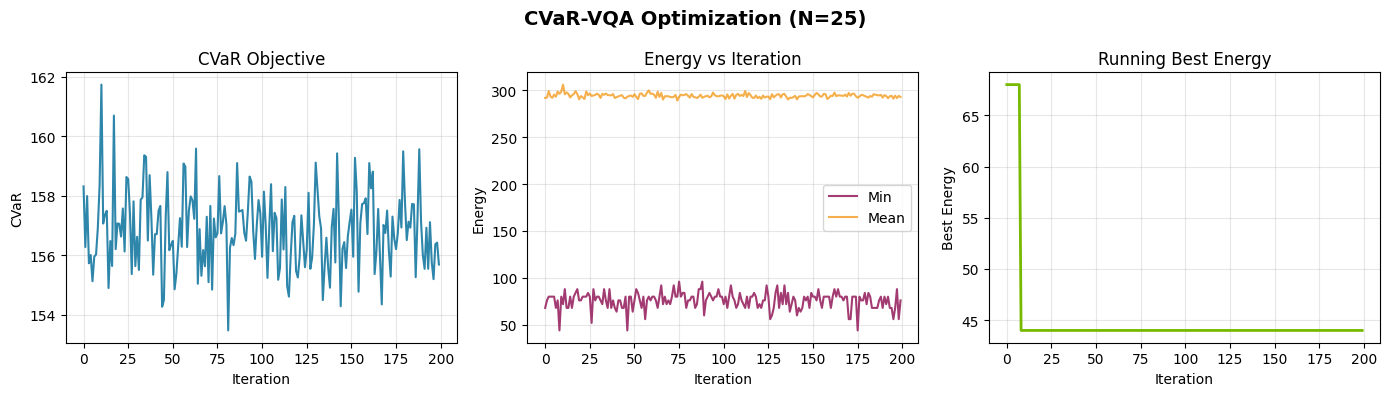

In [7]:
# Plot CVaR-VQA optimization history
fig = plot_optimization_history(results['vqa_result']['history'], title=f"CVaR-VQA Optimization (N={N})")
plt.show()


## Section 7: Analyzing TTS & scaling with respect to N

In [8]:
# =============================================================================
# LABS Known Optimal Energies (Packebusch & Mertens 2016)
# =============================================================================

# Known optimal LABS energies up to N=66
# Source: T. Packebusch and S. Mertens, J. Phys. A 49, 165001 (2016)
LABS_OPTIMAL_ENERGIES = {
    5: 2, 6: 4, 7: 3, 8: 8, 9: 12, 10: 13, 11: 5, 12: 10, 13: 6,
    14: 19, 15: 15, 16: 24, 17: 32, 18: 25, 19: 29, 20: 26,
    21: 26, 22: 39, 23: 47, 24: 36, 25: 36, 26: 45, 27: 37,
    28: 50, 29: 62, 30: 59, 31: 67, 32: 64, 33: 64, 34: 65,
    35: 73, 36: 82, 37: 86, 38: 87, 39: 99, 40: 108, 41: 108,
    42: 101, 43: 109, 44: 122, 45: 118, 46: 131, 47: 135, 48: 140,
    49: 136, 50: 153
}

def get_target_energy(N: int, tolerance_factor: float = 1.0) -> int:
    """
    Get target energy for TTS calculation.
    
    Args:
        N: Sequence length
        tolerance_factor: Multiplier for target (1.0 = exact optimal, 1.1 = 10% above)
        
    Returns:
        Target energy (rounded to int)
    """
    if N in LABS_OPTIMAL_ENERGIES:
        return int(LABS_OPTIMAL_ENERGIES[N] * tolerance_factor)
    else:
        # For unknown N, estimate using empirical formula E* ≈ 0.25 * N^1.5
        # This is a rough lower bound approximation
        estimated = 0.25 * (N ** 1.5)
        print(f"  Warning: N={N} optimal unknown, using estimate E*≈{estimated:.0f}")
        return int(estimated * tolerance_factor)


def merit_factor(N: int, E: int) -> float:
    """
    Compute merit factor F = N² / (2E).
    Higher is better. Best known F approaches ~12.1 for large N.
    """
    if E == 0:
        return float('inf')
    return (N ** 2) / (2.0 * E)

In [9]:
# =============================================================================
# Time-To-Solution (TTS) Experiment Framework
# =============================================================================
import time
from dataclasses import dataclass
from typing import Optional

@dataclass
class TTSResult:
    """Results from a single TTS experiment run."""
    N: int
    target_energy: int
    achieved_energy: int
    success: bool
    time_seconds: float
    iterations: int
    method: str
    
    @property
    def merit_factor(self) -> float:
        return (self.N ** 2) / (2.0 * self.achieved_energy) if self.achieved_energy > 0 else float('inf')


def run_cvar_vqa_tts_experiment(
    N: int,
    target_energy: int,
    n_layers: int = 3,
    cvar_alpha: float = 0.2,
    max_vqa_iterations: int = 100,
    vqa_shots: int = 512,
    max_mts_generations: int = 100,
    mts_pop_size: int = 20,
    seed: int = None
) -> TTSResult:
    """
    Run a single CVaR-VQA + MTS experiment and measure TTS.
    
    The experiment stops when target_energy is reached OR max iterations exhausted.
    
    Args:
        N: Sequence length
        target_energy: Energy threshold to reach (success criterion)
        n_layers: VQA ansatz layers
        cvar_alpha: CVaR parameter
        max_vqa_iterations: Max VQA optimization iterations
        vqa_shots: Shots per VQA iteration
        max_mts_generations: Max MTS generations after quantum seeding
        mts_pop_size: MTS population size
        seed: Random seed
        
    Returns:
        TTSResult with timing and success info
    """
    rng = np.random.default_rng(seed)
    start_time = time.time()
    total_iterations = 0
    best_energy = float('inf')
    
    # =========================================================================
    # Phase 1: CVaR-VQA Training
    # =========================================================================
    optimizer = CVaRVQAOptimizer(
        n_qubits=N,
        n_layers=n_layers,
        cvar_alpha=cvar_alpha,
        shots_per_iter=vqa_shots,
        seed=seed
    )
    
    # Custom objective that tracks early termination
    def objective_with_early_stop(params):
        nonlocal best_energy, total_iterations
        
        params_list = list(params)
        counts = cudaq.sample(
            optimizer.ansatz, 
            optimizer.n_qubits, 
            optimizer.n_layers, 
            params_list, 
            shots_count=optimizer.shots
        )
        
        energies, bitstrings = compute_energies_from_counts(counts)
        min_e = int(np.min(energies))
        
        if min_e < best_energy:
            best_energy = min_e
        
        total_iterations += 1
        
        # Early termination if target reached during VQA
        if best_energy <= target_energy:
            return -1e10  # Force optimizer to stop
        
        cvar_val = cvar_from_samples(energies, optimizer.cvar_alpha)
        
        # Store samples
        for bitstr, count in counts.items():
            e = labs_energy(bits_to_pm1(bitstr))
            optimizer.all_samples[bitstr] = min(optimizer.all_samples.get(bitstr, float('inf')), e)
        
        optimizer.history['cvar'].append(cvar_val)
        optimizer.history['min_energy'].append(min_e)
        
        return cvar_val
    
    # Run VQA
    initial_params = rng.uniform(0, 2*np.pi, size=optimizer.n_params)
    result = minimize(
        objective_with_early_stop,
        initial_params,
        method="COBYLA",
        options={'maxiter': max_vqa_iterations, 'disp': False}
    )
    
    vqa_time = time.time() - start_time
    
    # Check if target already reached during VQA
    if best_energy <= target_energy:
        return TTSResult(
            N=N,
            target_energy=target_energy,
            achieved_energy=best_energy,
            success=True,
            time_seconds=vqa_time,
            iterations=total_iterations,
            method="CVaR-VQA"
        )
    
    # =========================================================================
    # Phase 2: Sample from optimized circuit
    # =========================================================================
    final_counts = optimizer.sample_optimized(result.x, shots=2048)
    
    # =========================================================================
    # Phase 3: MTS from quantum seeds
    # =========================================================================
    pop_quantum = population_from_counts(final_counts, mts_pop_size, rng)
    
    # MTS with early termination
    population = [np.array(s) for s in pop_quantum]
    energies = []
    
    # Initial tabu search on population
    for i in range(len(population)):
        s, e = tabu_search(population[i], max_iters=200, tabu_tenure=7)
        population[i] = s
        energies.append(e)
        total_iterations += 1
        
        if e < best_energy:
            best_energy = e
            if best_energy <= target_energy:
                return TTSResult(
                    N=N,
                    target_energy=target_energy,
                    achieved_energy=best_energy,
                    success=True,
                    time_seconds=time.time() - start_time,
                    iterations=total_iterations,
                    method="CVaR-VQA+MTS"
                )
    
    # MTS generations
    for gen in range(max_mts_generations):
        i1, i2 = rng.integers(0, len(population), size=2)
        child = combine(population[i1], population[i2], rng)
        child = mutate(child, 0.02, rng)
        child, child_energy = tabu_search(child, max_iters=200, tabu_tenure=7)
        total_iterations += 1
        
        if child_energy < best_energy:
            best_energy = child_energy
            replace_idx = rng.integers(0, len(population))
            population[replace_idx] = child
            energies[replace_idx] = child_energy
            
            if best_energy <= target_energy:
                return TTSResult(
                    N=N,
                    target_energy=target_energy,
                    achieved_energy=best_energy,
                    success=True,
                    time_seconds=time.time() - start_time,
                    iterations=total_iterations,
                    method="CVaR-VQA+MTS"
                )
    
    # Did not reach target
    return TTSResult(
        N=N,
        target_energy=target_energy,
        achieved_energy=best_energy,
        success=False,
        time_seconds=time.time() - start_time,
        iterations=total_iterations,
        method="CVaR-VQA+MTS"
    )


def run_random_mts_tts_experiment(
    N: int,
    target_energy: int,
    max_mts_generations: int = 100,
    mts_pop_size: int = 20,
    seed: int = None
) -> TTSResult:
    """
    Run random-seeded MTS baseline for comparison.
    """
    rng = np.random.default_rng(seed)
    start_time = time.time()
    total_iterations = 0
    best_energy = float('inf')
    
    # Random initial population
    population = [random_sequence(N, rng) for _ in range(mts_pop_size)]
    energies = []
    
    # Initial tabu search
    for i in range(len(population)):
        s, e = tabu_search(population[i], max_iters=200, tabu_tenure=7)
        population[i] = s
        energies.append(e)
        total_iterations += 1
        
        if e < best_energy:
            best_energy = e
            if best_energy <= target_energy:
                return TTSResult(
                    N=N,
                    target_energy=target_energy,
                    achieved_energy=best_energy,
                    success=True,
                    time_seconds=time.time() - start_time,
                    iterations=total_iterations,
                    method="Random+MTS"
                )
    
    # MTS generations
    for gen in range(max_mts_generations):
        i1, i2 = rng.integers(0, len(population), size=2)
        child = combine(population[i1], population[i2], rng)
        child = mutate(child, 0.02, rng)
        child, child_energy = tabu_search(child, max_iters=200, tabu_tenure=7)
        total_iterations += 1
        
        if child_energy < best_energy:
            best_energy = child_energy
            replace_idx = rng.integers(0, len(population))
            population[replace_idx] = child
            energies[replace_idx] = child_energy
            
            if best_energy <= target_energy:
                return TTSResult(
                    N=N,
                    target_energy=target_energy,
                    achieved_energy=best_energy,
                    success=True,
                    time_seconds=time.time() - start_time,
                    iterations=total_iterations,
                    method="Random+MTS"
                )
    
    return TTSResult(
        N=N,
        target_energy=target_energy,
        achieved_energy=best_energy,
        success=False,
        time_seconds=time.time() - start_time,
        iterations=total_iterations,
        method="Random+MTS"
    )


# =============================================================================
# Median TTS Calculation (per paper methodology)
# =============================================================================

def compute_tts_99(results: list, target_time_per_run: float = None) -> dict:
    """
    Compute TTS for 99% success probability using replicate data.
    
    TTS_99 = t_median * log(1-0.99) / log(1-p_success)
    
    Where p_success is the empirical success rate.
    """
    successes = [r for r in results if r.success]
    n_success = len(successes)
    n_total = len(results)
    p_success = n_success / n_total if n_total > 0 else 0
    
    if n_success == 0:
        return {
            'tts_99': float('inf'),
            'median_time': float('inf'),
            'p_success': 0,
            'n_replicates': n_total,
            'n_success': 0
        }
    
    # Median time among successful runs
    success_times = sorted([r.time_seconds for r in successes])
    median_time = np.median(success_times)
    
    # TTS for 99% success probability
    if p_success >= 1.0:
        tts_99 = median_time
    else:
        tts_99 = median_time * np.log(1 - 0.99) / np.log(1 - p_success)
    
    return {
        'tts_99': tts_99,
        'median_time': median_time,
        'p_success': p_success,
        'n_replicates': n_total,
        'n_success': n_success,
        'success_times': success_times
    }


def run_median_tts_experiment(
    N: int,
    n_replicates: int = 10,
    tolerance_factor: float = 1.0,
    n_layers: int = 3,
    cvar_alpha: float = 0.2,
    max_vqa_iterations: int = 50,
    vqa_shots: int = 256,
    max_mts_generations: int = 50,
    mts_pop_size: int = 15,
    verbose: bool = True
) -> dict:
    """
    Run full median TTS experiment comparing CVaR-VQA+MTS vs Random+MTS.
    
    Args:
        N: Sequence length
        n_replicates: Number of independent runs (paper uses 11 for median)
        tolerance_factor: Target energy = optimal * tolerance_factor
        Other params: Algorithm hyperparameters
        
    Returns:
        Dictionary with TTS results for both methods
    """
    target_energy = get_target_energy(N, tolerance_factor)
    
    if verbose:
        print(f"=" * 60)
        print(f"Median TTS Experiment: N={N}")
        print(f"=" * 60)
        print(f"  Target energy: {target_energy}")
        if N in LABS_OPTIMAL_ENERGIES:
            print(f"  Known optimal: {LABS_OPTIMAL_ENERGIES[N]}")
            print(f"  Target merit factor: {merit_factor(N, target_energy):.2f}")
        print(f"  Replicates: {n_replicates}")
        print()
    
    # Run CVaR-VQA + MTS replicates
    quantum_results = []
    if verbose:
        print("[CVaR-VQA + MTS]")
    for i in range(n_replicates):
        result = run_cvar_vqa_tts_experiment(
            N=N,
            target_energy=target_energy,
            n_layers=n_layers,
            cvar_alpha=cvar_alpha,
            max_vqa_iterations=max_vqa_iterations,
            vqa_shots=vqa_shots,
            max_mts_generations=max_mts_generations,
            mts_pop_size=mts_pop_size,
            seed=42 + i
        )
        quantum_results.append(result)
        if verbose:
            status = "✓" if result.success else "✗"
            print(f"  Rep {i+1}: {status} E={result.achieved_energy}, t={result.time_seconds:.2f}s")
    
    # Run Random + MTS replicates
    random_results = []
    if verbose:
        print("\n[Random + MTS]")
    for i in range(n_replicates):
        result = run_random_mts_tts_experiment(
            N=N,
            target_energy=target_energy,
            max_mts_generations=max_mts_generations + max_vqa_iterations,  # Fair comparison
            mts_pop_size=mts_pop_size,
            seed=42 + i
        )
        random_results.append(result)
        if verbose:
            status = "✓" if result.success else "✗"
            print(f"  Rep {i+1}: {status} E={result.achieved_energy}, t={result.time_seconds:.2f}s")
    
    # Compute TTS statistics
    quantum_tts = compute_tts_99(quantum_results)
    random_tts = compute_tts_99(random_results)
    
    # Summary
    if verbose:
        print("\n" + "=" * 60)
        print("RESULTS")
        print("=" * 60)
        print(f"\nCVaR-VQA + MTS:")
        print(f"  Success rate: {quantum_tts['p_success']*100:.1f}%")
        print(f"  Median time (success): {quantum_tts['median_time']:.2f}s")
        print(f"  TTS (99%): {quantum_tts['tts_99']:.2f}s")
        
        print(f"\nRandom + MTS:")
        print(f"  Success rate: {random_tts['p_success']*100:.1f}%")
        print(f"  Median time (success): {random_tts['median_time']:.2f}s")
        print(f"  TTS (99%): {random_tts['tts_99']:.2f}s")
        
        if quantum_tts['tts_99'] < random_tts['tts_99']:
            speedup = random_tts['tts_99'] / quantum_tts['tts_99']
            print(f"\n  → CVaR-VQA+MTS is {speedup:.2f}x faster")
        elif random_tts['tts_99'] < quantum_tts['tts_99']:
            speedup = quantum_tts['tts_99'] / random_tts['tts_99']
            print(f"\n  → Random+MTS is {speedup:.2f}x faster")
    
    return {
        'N': N,
        'target_energy': target_energy,
        'quantum': quantum_tts,
        'random': random_tts,
        'quantum_results': quantum_results,
        'random_results': random_results
    }

In [10]:
# =============================================================================
# Scaling Analysis (run experiments across multiple N)
# =============================================================================

def run_scaling_analysis(
    N_values: list,
    n_replicates: int = 4,
    tolerance_factor: float = 1.0,
    **kwargs
) -> dict:
    """
    Run TTS experiments across multiple N values to analyze scaling.
    
    This mimics the methodology from the QE-MTS paper (arXiv:2511.04553)
    which measured scaling exponents by fitting log(TTS) vs N.
    """
    print("=" * 70)
    print("SCALING ANALYSIS: CVaR-VQA+MTS vs Random+MTS")
    print("=" * 70)
    
    results = {}
    for N in N_values:
        print(f"\n{'='*70}")
        exp_result = run_median_tts_experiment(
            N=N,
            n_replicates=n_replicates,
            tolerance_factor=tolerance_factor,
            **kwargs
        )
        results[N] = exp_result
    
    # Summary table
    print("\n" + "=" * 70)
    print("SCALING SUMMARY")
    print("=" * 70)
    print(f"{'N':>4} | {'Target':>8} | {'QE Success':>10} | {'QE TTS':>10} | {'Rand TTS':>10} | {'Speedup':>8}")
    print("-" * 70)
    
    for N in N_values:
        r = results[N]
        q_tts = r['quantum']['tts_99']
        r_tts = r['random']['tts_99']
        q_succ = r['quantum']['p_success'] * 100
        speedup = r_tts / q_tts if q_tts > 0 and q_tts != float('inf') else float('nan')
        
        q_tts_str = f"{q_tts:.2f}s" if q_tts != float('inf') else "inf"
        r_tts_str = f"{r_tts:.2f}s" if r_tts != float('inf') else "inf"
        speedup_str = f"{speedup:.2f}x" if not np.isnan(speedup) else "N/A"
        
        print(f"{N:>4} | {r['target_energy']:>8} | {q_succ:>9.1f}% | {q_tts_str:>10} | {r_tts_str:>10} | {speedup_str:>8}")
    
    return results

In [16]:
# =============================================================================
# EXPERIMENT: Set target for GPU simulator
# =============================================================================
# Switch to GPU for larger N
cudaq.set_target("nvidia")  # Use GPU simulator

# Test regime: N where classical heuristics start to struggle
# The paper says that  advantage emerges around N >= 47

# Quick test on moderate N (doable on GPU)
results = run_median_tts_experiment(
    N=25,                      
    n_replicates=5,            
    tolerance_factor=1.0,      # Exact optimal target
    n_layers=3,                # More layers for expressivity
    cvar_alpha=0.1,            # Focus on best X%
    max_vqa_iterations=60,     # Allow convergence
    vqa_shots=1024,             # More shots for better gradients
    max_mts_generations=100,
    mts_pop_size=20
)

Median TTS Experiment: N=25
  Target energy: 36
  Known optimal: 36
  Target merit factor: 8.68
  Replicates: 5

[CVaR-VQA + MTS]
  Rep 1: ✓ E=36, t=7.61s
  Rep 2: ✓ E=36, t=12.35s
  Rep 3: ✓ E=36, t=12.32s
  Rep 4: ✓ E=36, t=12.50s
  Rep 5: ✓ E=36, t=16.76s

[Random + MTS]
  Rep 1: ✓ E=36, t=1.46s
  Rep 2: ✓ E=36, t=0.53s
  Rep 3: ✓ E=36, t=3.07s
  Rep 4: ✓ E=36, t=3.80s
  Rep 5: ✓ E=36, t=0.72s

RESULTS

CVaR-VQA + MTS:
  Success rate: 100.0%
  Median time (success): 12.35s
  TTS (99%): 12.35s

Random + MTS:
  Success rate: 100.0%
  Median time (success): 1.46s
  TTS (99%): 1.46s

  → Random+MTS is 8.44x faster


In [11]:
# Full scaling analysis (GPU recommended for N >= 20)
scaling_results = run_scaling_analysis(
    N_values=[10,13,15,17,19,20,22,25,27,30],  # Range where advantage should emerge
    n_replicates=5,
    tolerance_factor=1.0,
    n_layers=3,
    cvar_alpha=0.15,
    max_vqa_iterations=100,
    vqa_shots=1024,
    max_mts_generations=80,
    mts_pop_size=20
)

SCALING ANALYSIS: CVaR-VQA+MTS vs Random+MTS

Median TTS Experiment: N=10
  Target energy: 13
  Known optimal: 13
  Target merit factor: 3.85
  Replicates: 5

[CVaR-VQA + MTS]
  Rep 1: ✓ E=13, t=1.52s
  Rep 2: ✓ E=13, t=1.00s
  Rep 3: ✓ E=13, t=1.30s
  Rep 4: ✓ E=13, t=1.41s
  Rep 5: ✓ E=13, t=1.03s

[Random + MTS]
  Rep 1: ✓ E=13, t=0.05s
  Rep 2: ✓ E=13, t=0.05s
  Rep 3: ✓ E=13, t=0.05s
  Rep 4: ✓ E=13, t=0.05s
  Rep 5: ✓ E=13, t=0.05s

RESULTS

CVaR-VQA + MTS:
  Success rate: 100.0%
  Median time (success): 1.30s
  TTS (99%): 1.30s

Random + MTS:
  Success rate: 100.0%
  Median time (success): 0.05s
  TTS (99%): 0.05s

  → Random+MTS is 26.77x faster

Median TTS Experiment: N=13
  Target energy: 6
  Known optimal: 6
  Target merit factor: 14.08
  Replicates: 5

[CVaR-VQA + MTS]
  Rep 1: ✓ E=6, t=2.87s
  Rep 2: ✓ E=6, t=2.91s
  Rep 3: ✓ E=6, t=2.74s
  Rep 4: ✓ E=6, t=2.54s
  Rep 5: ✓ E=6, t=2.74s

[Random + MTS]
  Rep 1: ✓ E=6, t=0.07s
  Rep 2: ✓ E=6, t=0.07s
  Rep 3: ✓ E=6, t=0.07s


In [ ]:
# =============================================================================
# Scaling Analysis: Fit log(TTS) vs N
# =============================================================================
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np

def analyze_scaling(scaling_results: dict, title: str = "TTS Scaling Analysis"):
    """
    Fit log(TTS) vs N to determine scaling exponents.
    
    TTS ~ O(base^N) implies log(TTS) = a + N*log(base)
    So the slope gives log(base), and base = exp(slope).
    
    Args:
        scaling_results: Output from run_scaling_analysis()
        title: Plot title
        
    Returns:
        Dictionary with fit parameters and scaling bases
    """
    # Extract data
    N_values = []
    quantum_tts = []
    random_tts = []
    
    for N, result in scaling_results.items():
        q_tts = result['quantum']['tts_99']
        r_tts = result['random']['tts_99']
        
        # Only include finite TTS values
        if q_tts != float('inf') and r_tts != float('inf'):
            N_values.append(N)
            quantum_tts.append(q_tts)
            random_tts.append(r_tts)
    
    N_values = np.array(N_values)
    quantum_tts = np.array(quantum_tts)
    random_tts = np.array(random_tts)
    
    # Log transform for linear fit
    log_quantum_tts = np.log(quantum_tts)
    log_random_tts = np.log(random_tts)
    
    # Linear regression: log(TTS) = a + b*N
    # Quantum fit
    slope_q, intercept_q, r_q, p_q, se_q = linregress(N_values, log_quantum_tts)
    base_q = np.exp(slope_q)
    
    # Random fit
    slope_r, intercept_r, r_r, p_r, se_r = linregress(N_values, log_random_tts)
    base_r = np.exp(slope_r)
    
    print("=" * 60)
    print("SCALING ANALYSIS RESULTS")
    print("=" * 60)
    print(f"\nCVaR-VQA + MTS:")
    print(f"  Fit: log(TTS) = {intercept_q:.3f} + {slope_q:.4f} * N")
    print(f"  Scaling base: {base_q:.4f}")
    print(f"  → TTS ~ O({base_q:.2f}^N)")
    print(f"  R² = {r_q**2:.4f}")
    
    print(f"\nRandom + MTS:")
    print(f"  Fit: log(TTS) = {intercept_r:.3f} + {slope_r:.4f} * N")
    print(f"  Scaling base: {base_r:.4f}")
    print(f"  → TTS ~ O({base_r:.2f}^N)")
    print(f"  R² = {r_r**2:.4f}")
    
    print(f"\nComparison:")
    print(f"  Quantum scaling: O({base_q:.2f}^N)")
    print(f"  Random scaling:  O({base_r:.2f}^N)")
    if base_q < base_r:
        ratio = base_r / base_q
        print(f"  → CVaR-VQA+MTS has {ratio:.2f}x better scaling base!")
    else:
        ratio = base_q / base_r
        print(f"  → Random+MTS has {ratio:.2f}x better scaling base")
    
    # Reference values from QE-MTS paper
    print(f"\n  Reference (QE-MTS paper):")
    print(f"    QE-MTS: O(1.24^N)")
    print(f"    MTS:    O(1.34^N)")
    print(f"    QAOA:   O(1.46^N)")
    
    # ==========================================================================
    # PLOTTING
    # ==========================================================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: log(TTS) vs N with fits
    ax1 = axes[0]
    
    # Data points
    ax1.scatter(N_values, log_quantum_tts, s=100, c='#76b900', marker='o', 
                label=f'CVaR-VQA+MTS (data)', zorder=5, edgecolor='black')
    ax1.scatter(N_values, log_random_tts, s=100, c='#E63946', marker='s', 
                label=f'Random+MTS (data)', zorder=5, edgecolor='black')
    
    # Fit lines (extended for extrapolation)
    N_fit = np.linspace(min(N_values) - 2, max(N_values) + 5, 100)
    ax1.plot(N_fit, intercept_q + slope_q * N_fit, '--', color='#76b900', linewidth=2,
             label=f'Fit: O({base_q:.2f}$^N$)')
    ax1.plot(N_fit, intercept_r + slope_r * N_fit, '--', color='#E63946', linewidth=2,
             label=f'Fit: O({base_r:.2f}$^N$)')
    
    # Reference lines from paper (optional)
    # ax1.plot(N_fit, intercept_q + np.log(1.24) * N_fit, ':', color='gray', alpha=0.5,
    #          label='Reference O(1.24^N)')
    
    ax1.set_xlabel('Sequence Length N', fontsize=12)
    ax1.set_ylabel('log(TTS)', fontsize=12)
    ax1.set_title('Scaling: log(TTS) vs N', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(min(N_values) - 1, max(N_values) + 3)
    
    # Plot 2: TTS vs N (log scale on y-axis)
    ax2 = axes[1]
    
    ax2.semilogy(N_values, quantum_tts, 'o-', color='#76b900', linewidth=2, 
                 markersize=10, label=f'CVaR-VQA+MTS: O({base_q:.2f}$^N$)', 
                 markeredgecolor='black')
    ax2.semilogy(N_values, random_tts, 's-', color='#E63946', linewidth=2, 
                 markersize=10, label=f'Random+MTS: O({base_r:.2f}$^N$)',
                 markeredgecolor='black')
    
    # Extrapolated fits
    ax2.semilogy(N_fit, np.exp(intercept_q + slope_q * N_fit), '--', 
                 color='#76b900', alpha=0.5, linewidth=1)
    ax2.semilogy(N_fit, np.exp(intercept_r + slope_r * N_fit), '--', 
                 color='#E63946', alpha=0.5, linewidth=1)
    
    ax2.set_xlabel('Sequence Length N', fontsize=12)
    ax2.set_ylabel('TTS (seconds, log scale)', fontsize=12)
    ax2.set_title('Time-to-Solution vs N', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper left', fontsize=10)
    ax2.grid(True, alpha=0.3, which='both')
    ax2.set_xlim(min(N_values) - 1, max(N_values) + 3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # ==========================================================================
    # Crossover point estimation
    # ==========================================================================
    if base_q < base_r:
        # Find N where quantum becomes faster
        # TTS_q = TTS_r → exp(a_q + b_q*N) = exp(a_r + b_r*N)
        # → a_q + b_q*N = a_r + b_r*N
        # → N = (a_r - a_q) / (b_q - b_r)
        if slope_q != slope_r:
            crossover_N = (intercept_r - intercept_q) / (slope_q - slope_r)
            print(f"\n  Estimated crossover point: N ≈ {crossover_N:.1f}")
            print(f"  (Quantum faster for N > {crossover_N:.0f})")
    
    return {
        'quantum': {
            'slope': slope_q,
            'intercept': intercept_q,
            'base': base_q,
            'r_squared': r_q**2
        },
        'random': {
            'slope': slope_r,
            'intercept': intercept_r,
            'base': base_r,
            'r_squared': r_r**2
        },
        'N_values': N_values,
        'quantum_tts': quantum_tts,
        'random_tts': random_tts
    }


# =============================================================================
# Run the analysis on your scaling results
# =============================================================================

# After running your scaling analysis:
fit_results = analyze_scaling(scaling_results, title="CVaR-VQA vs Random Scaling (LABS)")